# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

##### &#9658; [View table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
import torch.nn
import torch.optim
import torch.utils.data

In [3]:
import mls.torch

## Design Patterns for Supervised Deep Learning

The modern "deep learning" era started around 2012 (with [this paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)) when the architectures described below were first used successfully in the annual [ImageNet](https://en.wikipedia.org/wiki/ImageNet) competition, and the necessary large-scale computing and datasets were available. Massive neural networks are now the state of the art for many benchmark problems, including image classification, speech recognition and language translation.

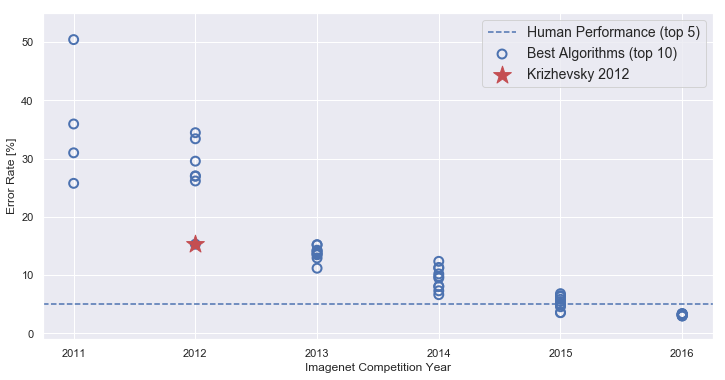

In [4]:
def imagenet_history():
    # Adapted from https://gist.github.com/germank/a542f22be0dad004b18775a7976d1a0b
    # reporting the best results per-team (and top 10)
    data = {
        '2011': [0.25770, 0.31010, 0.35960, 0.50450],
        '2012': [0.15315, 0.26172, 0.26979, 0.27058, 0.29576, 0.33419, 0.34464],
        '2013': [0.11197, 0.12953, 0.13511, 0.13555, 0.13748, 0.13985, 0.14182, 0.14291, 0.15193, 0.15245],
        '2014': [0.06656, 0.07325, 0.0806, 0.08111, 0.09508, 0.09794, 0.10222, 0.11229, 0.11326, 0.12376],
        '2015': [0.03567, 0.03581, 0.04581, 0.04873, 0.05034, 0.05477, 0.05858, 0.06314, 0.06482, 0.06828],
        '2016': [0.02991, 0.03031, 0.03042, 0.03171, 0.03256, 0.03291, 0.03297, 0.03351, 0.03352, 0.03416]
    }
    x, y = zip(*[(year, 100 * score) for year in data for score in data[year]])    
    plt.figure(figsize=(12,6))
    plt.scatter(x, y, marker='o', facecolors='none', edgecolors='C0',lw=2, s=80, label='Best Algorithms (top 10)')
    plt.axhline(5.1, ls='--', label='Human Performance (top 5)')
    plt.scatter('2012', 100 * min(data['2012']), marker='*', c='r', s=350, label='Krizhevsky 2012')
    plt.xlabel('Imagenet Competition Year')
    plt.ylabel('Error Rate [%]')
    plt.ylim(-1, 55)
    plt.legend(fontsize=14)
    
imagenet_history()

Deep neural networks are "deep" in the sense of having many layers (hundreds). They are also "shallow" in their use of domain-specific knowledge, preferring brute force (machine-intensive) learning from unprocessed input data over (human-intensive) feature engineering.

In this notebook, we will focus on the key architectural "design patterns" that have enabled recent advances in the benchmark supervised learning problems:
 - convolutional layers.
 - skip connections.
 - feedback connections.
 
These are low-level building blocks, rather than complete end-to-end solutions to any problem, which are important to understand if you want to adapt existing solutions to your problem or design new architectures from scratch.

Progress on benchmark problems like ImageNet is generally not smooth because the space of possible "hyperdecisions" is too large to explore systematically. Instead, successful new ideas are discovered effectively by chance, followed by a period of small perturbations around the new approach. Since a large number of PhD students are engaged in trying to discover the next big idea, this hyper-optimization process is sometimes referred to as "grad student descent".

Finally, we mention "transfer learning" where the goal is to adapt an existing end-to-end solution to solve a closely related problem.

### Test Problem

We start by defining a test problem: learn how to "de-noise" samples from a smooth 1D function $y = f(x)$. Each input tensor consists of $N=128$ values of
$$
X_\text{in} = \left[ f(x_i) + \epsilon_i \right]_{i=1}^N
$$
with $x_i$ on a uniform grid, where $\epsilon_i$ is drawn from a normal distribution (with a different variance for each function $f$. The corresponding target values are the noise-free function values:
$$
Y_\text{tgt} = \left[ f(x_i)\right]_{i=1}^N \; .
$$
The functions $f(x)$ are sampled from a Gaussian process prior:

In [5]:
def gpsample(x, ngen, gen, sig0=0.5, lam=0.5):
    """Draw samples from a Gaussian process function prior.
    """
    # Tabulate K for each pair of elements in x.
    xT = x.reshape(-1, 1)
    K = sig0 ** 2 * np.exp(-0.5 * ((xT - x) / lam) ** 2)
    # Generate random samples of f(x).
    mu = np.zeros_like(x)
    return gen.multivariate_normal(mu, K, size=ngen)

Sample the noise for each input from a normal distribution with a different (random) variance:

In [6]:
N_train, N_test, D = 1000, 100, 128
x_sample = np.linspace(-1, 1, D)
gen = np.random.RandomState(seed=123)
y_train = torch.tensor(gpsample(x_sample, ngen=N_train, gen=gen).astype(np.float32))
y_test = torch.tensor(gpsample(x_sample, ngen=N_test, gen=gen).astype(np.float32))
# Generate randome noise levels.
torch.manual_seed(123)
noise_rms = 0.02 + 0.08 * torch.rand(N_train)
x_train = y_train + noise_rms.reshape(-1, 1) * torch.randn((N_train, D))
noise_rms = 0.02 + 0.08 * torch.rand(N_test)
x_test = y_test + noise_rms.reshape(-1, 1) * torch.randn((N_test, D))
# Package into datasets.
train_data = torch.utils.data.TensorDataset(x_train, y_train)
test_data = torch.utils.data.TensorDataset(x_test, y_test)

Define a plot utility that we wil re-use below to assess the quality of  predictions $Y_\text{pred}$ from different methods applied to the test data:

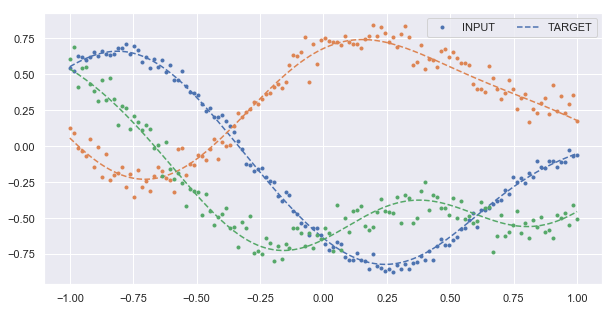

In [7]:
def plot_test(y_pred=None, n_test=3):
    plt.figure(figsize=(10, 5))
    for i in range(n_test):
        x, y = test_data[i]
        P = plt.plot(x_sample, x.numpy(), '.', label='INPUT' if i == 0 else None)
        c = P[-1].get_color()
        if y_pred is not None:
            plt.plot(x_sample, y_pred[i].detach().numpy(), '-',c='k', label='PRED' if i == 0 else None)
        plt.plot(x_sample, y.numpy(), '--', c=c, label='TARGET' if i == 0 else None)
    plt.legend(ncol=3)
    
plot_test()

Note how the Gaussian process hyperparameters we are using make this a relatively easy task, since the noise adds mostly high frequencies while the prior only contributes low frequencies (long wavelengths).

### Fully Connected Baseline

Before diving into new design patterns, let's establish a baseline using a plain fully connected network with 128 inputs and 128 outputs.

In order conveniently build networks with different architectures, define a class that fills a [Sequential container](https://pytorch.org/docs/stable/nn.html#sequential) via constructor code:

In [8]:
class FCN(torch.nn.Sequential):
    
    def __init__(self, *n_nodes, activation=torch.nn.ReLU):
        super(FCN, self).__init__()
        n_inputs = n_nodes[:-1]
        n_outputs = n_nodes[1:]
        for depth, (n_inp, n_out) in enumerate(zip(n_inputs, n_outputs)):
            self.add_module(f'LYR{depth}', torch.nn.Linear(n_inp, n_out))
            if depth < len(n_inputs) - 1:
                self.add_module(f'ACT{depth}', activation())

In [9]:
FCN(1, 2, 3, 4)

FCN(
  (LYR0): Linear(in_features=1, out_features=2, bias=True)
  (ACT0): ReLU()
  (LYR1): Linear(in_features=2, out_features=3, bias=True)
  (ACT1): ReLU()
  (LYR2): Linear(in_features=3, out_features=4, bias=True)
)

We will use the MSE (L2) loss throughout:

In [10]:
loss_fn = torch.nn.MSELoss()

Build a generic learning loop that we will re-use for all the models below. Note that we are using the [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) this time (since it generally requires less hyperparameter tuning than SGD):

In [11]:
def learn(model, n_epochs=100, batch_size=100, learning_rate=0.05,
          loss_slice=slice(None, None), n_print=1):
    print(f'Model has {np.sum([np.prod(P.shape) for P in model.parameters()])} parameters.')
    loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    print(f'Data has {np.prod(loader.dataset.tensors[0].shape)} values.')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    x_test, y_test = test_data.tensors
    train_loss, test_loss = [], []
    print_at = np.round((1 + np.arange(n_print)) / n_print * n_epochs).astype(int)
    for epoch in range(n_epochs):
        model.train()
        for x_train, y_train in loader:
            y_pred = model(x_train)
            loss = loss_fn(y_pred[:,loss_slice], y_train[:,loss_slice])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss.append(float(loss.data))
        model.eval()
        y_pred = model(x_test)
        test_loss.append(float(loss_fn(y_pred[:,loss_slice], y_test[:,loss_slice]).data))
        if epoch + 1 == print_at[0]:
            print(f'EPOCH {epoch + 1:5d}: TRAIN {train_loss[-1]:.5f} TEST {test_loss[-1]:.5f}')
            print_at = print_at[1:]
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, '.', label='TRAIN')
    plt.plot(test_loss, '.', label='TEST')
    plt.xlabel('Number of Epochs')
    plt.ylabel('MSE Loss')
    plt.yscale('log')
    plt.legend()
    return train_loss, test_loss, y_pred.detach()

Learn a model with a single hidden layer with 128 nodes, and plot some final predictions for the TEST data:

Model has 33024 parameters.
Data has 128000 values.
EPOCH   250: TRAIN 0.00019 TEST 0.00035


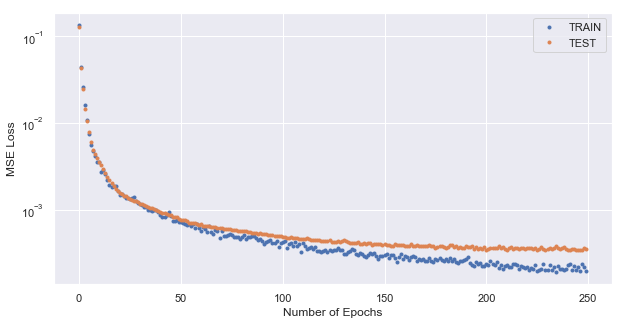

In [12]:
torch.manual_seed(123)
model = FCN(128, 128, 128)
train_loss, test_loss, y_pred = learn(model, learning_rate=0.001, n_epochs=250)

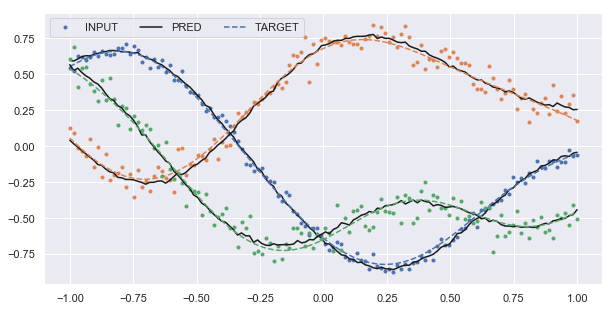

In [13]:
plot_test(y_pred)

**DISCUSS:**
 - There are indications that the network has overfitted the TRAIN data. What are they?
 - How might you minimize this overfitting?
 - Has the network learned to "high-pass filter" the noisy input?

### Convolutional Layers

Our first design pattern is to use [convolution arithmetic](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) as a replacement for the $n_\text{in}\times n_\text{out}$ matrix multiply of a [Linear layer](https://pytorch.org/docs/stable/nn.html#linear) (blue=inputs, green=outputs, gray=kernel, white=padding):

![convolution example](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif)

This approach can drastically reduce the number of weights that need to be learned since the same small "kernel" matrix of weights is applied at different positions of the input. It is justified when:
 - The input features measure some property sampled on a uniform grid (spatial / temporal / abstract).
 - The learning task is (at least approximately) translation invariant on the grid.

Convolutions are most often applied to 2D inputs (aka images), but also work just as well for the 1D and 3D datasets that are common in scientific problems. The basic convolution has several hyperparameters that determine exactly how the kernel is tiled across (a single channel of) the input:
 - **kernel size**: how big is the kernel matrix? (this determines the number of layer parameters).
 - **stride**: how many grid units does the kernel advance each time?
 - **padding**: is the input padded (usually with zeros)?
 - **dilation**: is the kernel dense or expanded over the input grid?

The combination of these hyperparameters, together with the input size, determine the output size.
 
Instead of summing kernel-weighted inputs to calculate a single output value, we can instead distribute each input value over the output using kernel weights, i.e., flip the inputs and outputs in the diagram above. This is the linear inverse of a convolution but can be transformed into a normal convolution where the [kernel matrix has been transposed](https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8). These are known as **transposed convolutions** (they are also sometime referred to (incorrectly) as "deconvolutions").

Convolutions can be applied in parallel (and independently) to multiple **channels** of data. The main use case for this for input data is to support the RGB channels of color images. However, hidden convolutional layers often use a large number (hundreds) of channels. A common design pattern is to keep the data length the same or decreasing, while increasing the number of channels.

Convolution is a layer design, so there is still the question of how to stack layers into a full network. There are no rules here, but most of the successful image classification networks have 10-100 convolutional layers, to identify high-level image features, followed by some fully connected layers to perform the final classification task. Here are some examples:

![convolutional architectures](img/NeuralNetworks/convnets.png)

Modify the `FCN` class above to build a network consisting entirely of convolution layers (which do not change the input size):

In [14]:
class CNN(torch.nn.Sequential):
    
    def __init__(self, kernels=(5, 5, 5), channels=(1, 3, 3, 1), activation=torch.nn.ReLU):
        super(CNN, self).__init__()
        if len(channels) != len(kernels) + 1:
            raise ValueError('Input kernels and channels have inconsistent lengths.')
        for depth, (K, Cin, Cout) in enumerate(zip(kernels, channels[:-1], channels[1:])):
            # Use a padding that gives output_size == input_size.
            assert K % 2 == 1, 'Kernel sizes must be odd.'
            self.add_module(f'LYR{depth}', torch.nn.Conv1d(
                in_channels=Cin, out_channels=Cout, kernel_size=K, padding=K // 2))
            if depth < len(kernels) - 1:
                self.add_module(f'ACT{depth}', activation())
    
    def forward(self, inp):
        # Assume in_channels==1 if the input has no channel axis.
        if len(inp.shape) == 2:
            inp = inp.unsqueeze(1)
        out = super(CNN, self).forward(inp)
        # Remove channel axis when out_channels==1.
        if out.shape[1] == 1:
            out = out.squeeze(1)
        return out

In [15]:
CNN(kernels=(5,), channels=(1, 1))

CNN(
  (LYR0): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(2,))
)

In [16]:
CNN(kernels=(5, 5), channels=(1, 2, 1))

CNN(
  (LYR0): Conv1d(1, 2, kernel_size=(5,), stride=(1,), padding=(2,))
  (ACT0): ReLU()
  (LYR1): Conv1d(2, 1, kernel_size=(5,), stride=(1,), padding=(2,))
)

In [17]:
CNN(kernels=(5, 5, 5), channels=(1, 2, 3, 1))

CNN(
  (LYR0): Conv1d(1, 2, kernel_size=(5,), stride=(1,), padding=(2,))
  (ACT0): ReLU()
  (LYR1): Conv1d(2, 3, kernel_size=(5,), stride=(1,), padding=(2,))
  (ACT1): ReLU()
  (LYR2): Conv1d(3, 1, kernel_size=(5,), stride=(1,), padding=(2,))
)

A recent idea is to use a layer with a 1x1 "convolution" to effectively apply a fully connected network that maps `in_channels` values per input to `out_channels` values per input. This is known as a **network-in-network** layer (see  [this paper](https://arxiv.org/pdf/1312.4400v3.pdf) for details):

In [18]:
CNN(kernels=(1, 1, 1, 1), channels=(1, 5, 10, 5, 1))

CNN(
  (LYR0): Conv1d(1, 5, kernel_size=(1,), stride=(1,))
  (ACT0): ReLU()
  (LYR1): Conv1d(5, 10, kernel_size=(1,), stride=(1,))
  (ACT1): ReLU()
  (LYR2): Conv1d(10, 5, kernel_size=(1,), stride=(1,))
  (ACT2): ReLU()
  (LYR3): Conv1d(5, 1, kernel_size=(1,), stride=(1,))
)

We are now ready to learn a convolutional model to solve our test de-noising problem:

Model has 1101 parameters.
Data has 128000 values.
EPOCH    25: TRAIN 0.00040 TEST 0.00036


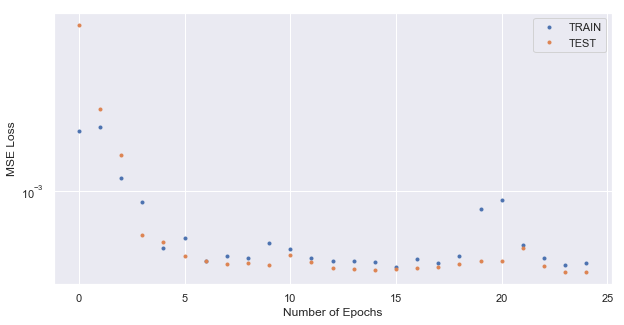

In [19]:
torch.manual_seed(123)
model = CNN((9, 9, 9), (1, 10, 10, 1))
train_loss, test_loss, y_pred = learn(model, n_epochs=25, learning_rate=0.01, loss_slice=slice(5, -5))

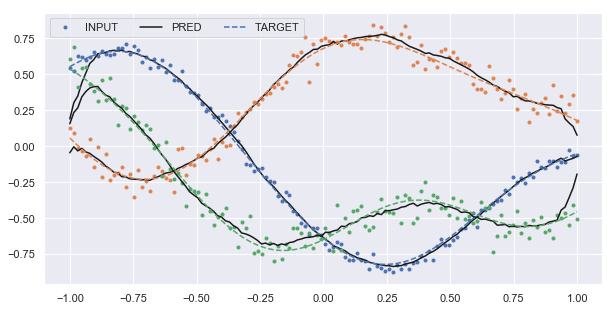

In [20]:
plot_test(y_pred)

How did we do? We achieved the same performance (TEST loss ~3e-4) with much few parameters (1K vs 33K), fewer epochs (25 vs 250) and less overfitting.

**DISCUSS:** There is some evidence that the convolutional model does poorly at the edges. Why is this not surprising? How does the `loss_slice` argument to the `learn()` function address this?

### Skip Connections

Convolution is an alternative method for introducing linear mixing of inputs to outputs. Our last two design patterns take a different approach: adding graph edges that do not connect adjacent layers. We first explore forward connections that "skip" over some subsequent modules.

The landmark papers that introduced the key ideas (together with end-to-end network architectures for solving a particular problem) are:
 - Ronneberger 2015 [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) aka "U-Net"
 - He 2015, [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) aka "ResNet"
 - Huang 2017 [Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993) aka "DenseNet"

To motivate the need for skip connections, define a utility to plot the parameter gradients calculated during a backwards pass through the network:

In [21]:
def plot_gradients(model, N=1000, D=100):
    out = model(torch.randn(1000, 100))
    loss = torch.sum(out ** 2) / 100
    loss.backward()
    grads = [lyr.weight.grad.data.view(-1) for lyr in model if isinstance(lyr, torch.nn.Linear)]
    bins = np.linspace(-.2, .2, 50)
    for depth, grad in enumerate(grads):
        plt.hist(grad, bins=bins, histtype='step', label=f'LYR{depth}')
    plt.yscale('log')
    plt.xlabel('Weight Gradient')
    plt.ylabel('Nodes / layer')
    plt.legend()

Next, generalize our `FCN` class to add a new `add_skip()` method, which allows arbitrary skip connections to be added to a fully connected network:

In [22]:
import collections

class SkipNet(FCN):
    """Initialize a fully connected network with arbitrary skip connections.
    """
    def __init__(self, *n_nodes, activation=torch.nn.ReLU):
        super(SkipNet, self).__init__(*n_nodes, activation=activation)
        self.skips = collections.defaultdict(list)
        
    def add_skip(self, out_of, in_to, verbose=True):
        """Add a skip connection from out_of -> in_to.
        """
        self.skips[in_to].append(out_of)
        if verbose:
            print(f'Output of {out_of} is added to input of {in_to}.')
        
    def forward(self, inp):
        saved = {}
        for name, module in self.named_children():
            # Add any contributions from skip connections to this module's input.
            for source in self.skips[name]:
                inp += saved[source]
            # Pass the input through this module.
            inp = module(inp)
            # Save this module's output for other modules to use as a skip input.
            saved[name] = inp
        return inp

With no skip connections, we clearly see the **vanishing gradient problem** with just 5 layers:

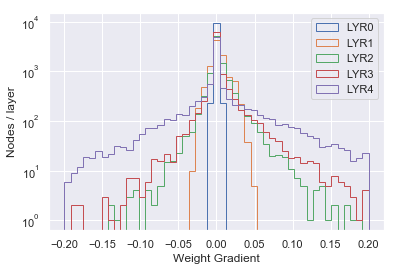

In [23]:
torch.manual_seed(123)
model = SkipNet(100, 100, 100, 100, 100, 100)
plot_gradients(model)

We can fix the problem for `LYR0` by adding a skip connection to `LYR1`:

Output of LYR0 is added to input of LYR1.


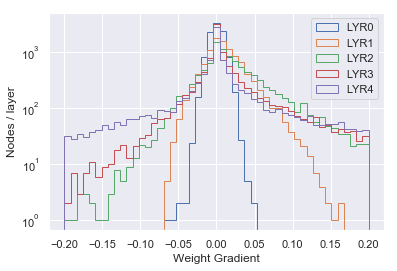

In [24]:
model.add_skip('LYR0', 'LYR1')
plot_gradients(model)

Adding skip connections that bypass each Linear+ReLU pair in turn cures the vanishing gradient problem:

Output of LYR1 is added to input of LYR2.
Output of LYR2 is added to input of LYR3.


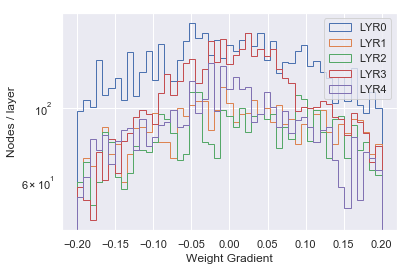

In [25]:
model.add_skip('LYR1', 'LYR2')
model.add_skip('LYR2', 'LYR3')
plot_gradients(model)

We can easily understand how this works from a "plumbing" perspective": the skip connection provides a parallel pipe for the backward propagation of gradients that bypasses the attenuating effect of each Linear+ReLU pair.

However, skip connections also transform the problem we are trying to solve in an important way. Instead of trying to explain our data with $f(x)$, we explain it with $x + f(x)$.  In other words, we are saying that the identify function is a good zeroth-order approximation and we want to learn the first-order correction.

### Feedback Connections

Our final design pattern is to introduce a backwards "feedback" connection. This simple modification adds significant complexity but also great expressive power (comparable to the electronics revolution associated with the idea of transistor feedback!)

Networks that include some feedback connections are known as **recurrent neural networks (RNN)**. They are currently the state of the art for many natural language tasks, such as translation, sentiment analysis and image captioning.

Architectures with feedback are still maturing but some useful building blocks have emerged, such as the long short-term memory (LSTM) and gated recurrent unit (GRU), which allows a network to remember some internal state but also forget it based on new input.

Since the same unit processes different parts of the input data many times, a RNN typically has much fewer parameters that a corresponding fully connected network (just like a CNN).

Some practical considerations for RNN designs:
 - The order of training data is now significant and defines a "model time", but the network can be reset whenever needed.
 - Input data can be packaged into variable-length messages that generate variable (and different) length output messages. This is exactly what language translation needs.

A feed-foward network implements a universal approximating function. Since the internal state of an RNN acts like local variables, you can think of an RNN as a universal approximating program!

Here are some useful references for further reading:
 - [The unreasonable effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
 - [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)

To motivate a recurrent architecture, we will first consider a simple (non parametric) running average solution to our test problem, packaged to look like a torch module:
$$
y_i = \frac{1}{n_\text{hist}}\, \left( x_i + \sum_{k=1}^{n_\text{hist}-1} x_{i-k} \right) \; .
$$

In [26]:
class RunningAverage(object):
    
    def __init__(self, n_history):
        self.n_history = n_history
        
    def forward(self, inp, history=None):
        if history is None:
            # Set the initial history to zeros.
            history = torch.zeros(self.n_history)
        # Shift the existing history and add the new input.
        history = history.roll(-1)
        history[-1] = inp
        return torch.mean(history), history
    
    def __call__(self, inp):
        history = None
        out = torch.empty_like(inp)
        for i in range(len(inp)):
            out[i], history = model.forward(inp[i], history)
        return out

Note that the `forward` method processes a single sample from one of our 128-value inputs, while the `__call__` method feeds each sample in turn to build a 128-value output prediction.

First check how this module behaves for simple inputs:

In [27]:
model = RunningAverage(n_history=4)
history = None
inp = 1.
for i in range(5):
    out, history = model.forward(inp, history)
    print(f'input: {inp}, output: {out:.2f} history: {history}')

input: 1.0, output: 0.25 history: tensor([0., 0., 0., 1.])
input: 1.0, output: 0.50 history: tensor([0., 0., 1., 1.])
input: 1.0, output: 0.75 history: tensor([0., 1., 1., 1.])
input: 1.0, output: 1.00 history: tensor([1., 1., 1., 1.])
input: 1.0, output: 1.00 history: tensor([1., 1., 1., 1.])


We normally feed in a whole input sample to build a corresponding output:

In [28]:
model(torch.ones(5))

tensor([0.2500, 0.5000, 0.7500, 1.0000, 1.0000])

How does this simple model perform on our test problem?

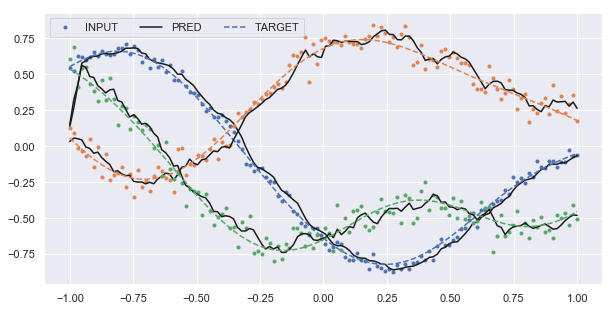

In [29]:
model = RunningAverage(n_history=4)
y_pred = [model(x) for x in x_test[:3]]
plot_test(y_pred)

Try increasing the amount of internal history to get smoother outputs:

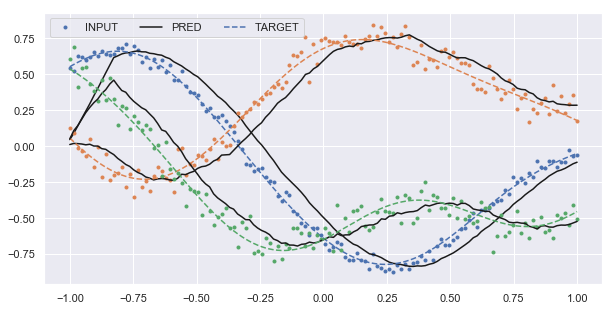

In [30]:
model = RunningAverage(n_history=12)
y_pred = [model(x) for x in x_test[:3]]
plot_test(y_pred)

The results are offset (which we could fix) and have problems at the left edge (due to the zero initial history) but are otherwise reasonable.

Next, replace the averaging equation above with a pair of small 3-layer fully connected networks: one to calculate the feedback value and one for the output value.

In [31]:
class RNN(torch.nn.Module):
    
    def __init__(self, n_feedback, activation=torch.nn.PReLU):
        super(RNN, self).__init__()
        self.n_feedback = n_feedback
        self.feedback_net = torch.nn.Sequential(
            torch.nn.Linear(1 + n_feedback, 2 * n_feedback, bias=True),
            activation(),
            torch.nn.Linear(2 * n_feedback, 2 * n_feedback),
            activation(),
            torch.nn.Linear(2 * n_feedback, n_feedback),
            activation(),
        )
        self.output_net = torch.nn.Sequential(
            torch.nn.Linear(1 + n_feedback, 2 * n_feedback),
            activation(),
            torch.nn.Linear(2 * n_feedback, 2 * n_feedback),
            activation(),
            torch.nn.Linear(2 * n_feedback, 1),
        )
        
    def forward(self, inp, feedback=None):
        if feedback is None:
            feedback = torch.zeros(len(inp), self.n_feedback)
        combined = torch.cat((inp, feedback), 1)
        feedback = self.feedback_net(combined)
        # Output is a residual!
        out = inp + self.output_net(combined)
        return out, feedback
    
    def __call__(self, inp):
        out = torch.empty_like(inp)
        feedback = None
        for i in range(inp.shape[1]):
            out[:, i:i+1], feedback = super(RNN, self).__call__(inp[:, i:i+1], feedback)
        return out

In [32]:
model = RNN(4)
history = None
inp = torch.ones((1, 1))
for i in range(5):
    out, history = model.forward(inp, history)
    print(f'input: {inp[0, 0]}, output: {out[0, 0]:.2f} history: {history[0].data}')

input: 1.0, output: 1.19 history: tensor([-0.0334,  0.0904, -0.0781,  0.2044])
input: 1.0, output: 1.20 history: tensor([-0.0347,  0.0752, -0.0781,  0.1982])
input: 1.0, output: 1.20 history: tensor([-0.0346,  0.0746, -0.0779,  0.1976])
input: 1.0, output: 1.20 history: tensor([-0.0346,  0.0746, -0.0779,  0.1976])
input: 1.0, output: 1.20 history: tensor([-0.0346,  0.0746, -0.0779,  0.1976])


Try this simple recurrent unit on our test problem:

Model has 2202 parameters.
Data has 128000 values.
EPOCH   100: TRAIN 0.00135 TEST 0.00127


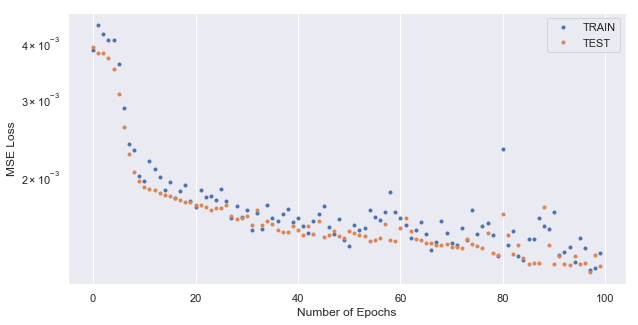

In [33]:
torch.manual_seed(123)
model = RNN(12)
train_loss, test_loss, y_pred = learn(model, batch_size=100, n_epochs=100, learning_rate=0.002)

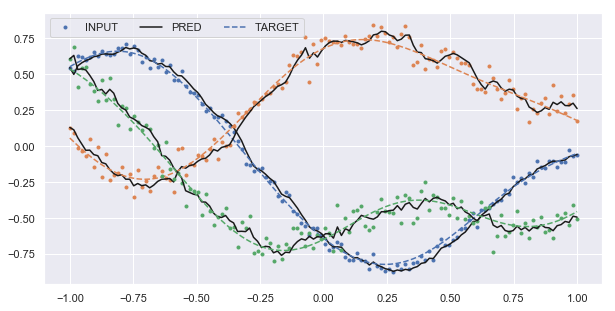

In [34]:
plot_test(y_pred)

Training is significantly slower because of the feedback loops, and the resulting performance is worse than our earlier architectures (but still not bad given the number of parameters, and has good generalization).

This problem does not take advantage of some of the unique RNN features, such as variable-length inputs and outputs. However, it does offer a solution that, once trained, can be run in "streaming mode" on the data, unlike our earlier architectures which need to see all of the data at once.

Finally, instead of building our own recurrent unit, we can use one of the [standard units](https://pytorch.org/docs/stable/nn.html#recurrent-layers), such as a GRU:

In [35]:
class GRU(torch.nn.Module):
    
    def __init__(self, n_feedback):
        super(GRU, self).__init__()
        self.gru = torch.nn.GRU(1, n_feedback, num_layers=1, batch_first=True)
        
    def __call__(self, inp):
        # Add last input_size=1 dimension to inp.
        hidden, _ = self.gru(inp.unsqueeze(-1))
        # Use the first element of final hidden state as residual.
        return inp + hidden[:, :, 0]

Model has 540 parameters.
Data has 128000 values.
EPOCH   100: TRAIN 0.00373 TEST 0.00343


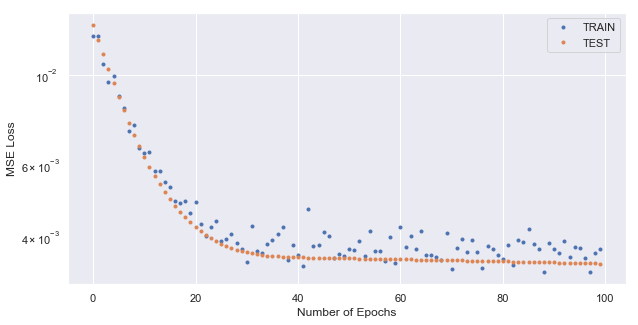

In [36]:
torch.manual_seed(123)
model = GRU(12)
train_loss, test_loss, y_pred = learn(model, batch_size=100, n_epochs=100, learning_rate=0.0002)

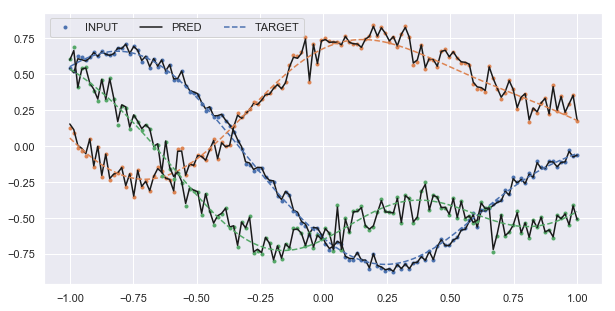

In [37]:
plot_test(y_pred)

Note how the GRU network has simply learned to pass through the input data, so has fallen into a false local minimum solution when we know there is a better solution out there.

### Transfer Learning

The methods described above are building-block design patterns that underly much of the recent development in "deep learning".  They are important to understand if you want to learn how the popular end-to-end solutions work and adapt them to your own problem.

However, an alternative (often easier) approach is **transfer learning**, where you:
 - Take an existing end-to-end solution to a similar problem with pre-trained parameters.
 - Replace the final (typically fully connected) layers.
 - Retrain the network with only the parameters of the new layers being updated.
 
This approach often allows you to benefit from the (often vast) resources already spent learning a model and adapt it to your problem with relatively little data or training time required.

The limits to this approach for scientific problems are that our problems are often superficially similar, but still different in some fundamentally important ways. The result of transfer learning is then often sub-optimal but can still be acceptable.

Transfer learning for image-processing problems is [straightforward with PyTorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) and even easier with the [fastai library](https://docs.fast.ai/).

For a list of some benchmark problems and the current best solutions, see [here](http://rodrigob.github.io/are_we_there_yet/build/#about).